<a href="https://colab.research.google.com/github/renatadecassiapires/adventure_works/blob/main/modelagem_desafio_LH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q7. Previsão de demanda - Produto

# 7.1. Instalações requeridas para o desenvolvimento do projeto

In [1]:
!pip install statsforecast
!pip install hierarchicalforecast

In [2]:
!pip install unidecode

  Using cached Unidecode-1.3.8-py3-none-any.whl (235 kB)


In [3]:
!pip install pandas-gbq

In [4]:
!pip install google-cloud-bigquery

In [5]:
from google.cloud import bigquery

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from unidecode import unidecode
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive, HoltWinters

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 7.2. Conexão com BigQuery

In [6]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery

project_id = 'adwsap'

table_id = 'tabela_modelagem_desafio'

client = bigquery.Client(project = project_id)

# 7.3 Visualização dataframe

In [7]:
query = client.query("select * from `adwsap.sap_adw.tabela_modelagem_desafio`")

df = query.to_dataframe()

df.head()

,id_detalhe_pedido,product_fk,customerid,shiptoadress_fk,creditcard_fk,unitprice,orderqty,revenue_wo_taxandfreight,orderdate,order_status_name,...,productstandardeost,productlistprice,productsize,productweight,productdaystonanufacture,productline,productclass,productstyle,productquantity,productunitprice
0,1145,214,29523,593,15321,4.750000000,26,123.500000000,2011-07-01 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,9922,214,29504,973,18031,4.750000000,32,152.000000000,2012-04-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,10783,348,29734,517,1346,14.500000000,11,159.500000000,2012-05-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,10900,348,29692,494,923,14.500000000,11,159.500000000,2012-05-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,14472,348,29699,456,10064,14.500000000,11,159.500000000,2012-06-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [13]:
df.tail()

,id_detalhe_pedido,product_fk,customerid,shiptoadress_fk,creditcard_fk,unitprice,orderqty,revenue_wo_taxandfreight,orderdate,order_status_name,...,productstandardeost,productlistprice,productsize,productweight,productdaystonanufacture,productline,productclass,productstyle,productquantity,productunitprice
121312,18970,270,29689,865,3070,454.134200000,12,5449.610400000,2012-08-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
121313,30170,270,30109,826,17594,454.134200000,11,4995.476200000,2013-02-28 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
121314,31047,270,29627,447,15954,454.134200000,13,5903.744600000,2013-03-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
121315,33607,270,29957,992,371,454.134200000,12,5449.610400000,2013-04-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
121316,35089,270,29637,559,5164,454.134200000,12,5449.610400000,2013-04-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   id_detalhe_pedido         121317 non-null  Int64              
 1   product_fk                121317 non-null  Int64              
 2   customerid                121317 non-null  Int64              
 3   shiptoadress_fk           121317 non-null  Int64              
 4   creditcard_fk             118744 non-null  Int64              
 5   unitprice                 121317 non-null  object             
 6   orderqty                  121317 non-null  Int64              
 7   revenue_wo_taxandfreight  121317 non-null  object             
 8   orderdate                 121317 non-null  datetime64[ns, UTC]
 9   order_status_name         121317 non-null  object             
 10  territoryid               87678 non-null   Int64              
 11  

In [14]:
df.shape

(121317, 30)

In [15]:
df.dtypes

id_detalhe_pedido                         Int64
product_fk                                Int64
customerid                                Int64
shiptoadress_fk                           Int64
creditcard_fk                             Int64
unitprice                                object
orderqty                                  Int64
revenue_wo_taxandfreight                 object
orderdate                   datetime64[ns, UTC]
order_status_name                        object
territoryid                               Int64
storename                                object
productid                                 Int64
productsalesid                            Int64
productcompleteid                         Int64
productname                              object
productaakeflag                          object
productfinishedgoodsflag                 object
productsafetystocklevel                  object
productreorderpoint                      object
productstandardeost                     

In [16]:
df.describe()

,id_detalhe_pedido,product_fk,customerid,shiptoadress_fk,creditcard_fk,orderqty,territoryid,productid,productsalesid,productcompleteid
count,121317.0,121317.0,121317.0,121317.0,118744.0,121317.0,87678.0,121317.0,121317.0,121317.0
mean,60659.0,346.680836,24345.630505,5536.210309,9795.943787,2.26608,4.943623,841.680836,841.680836,841.680836
std,35021.345641,86.452124,6689.110387,6121.624676,5639.333551,2.491323,2.712893,86.452124,86.452124,86.452124
min,1.0,212.0,11000.0,9.0,1.0,1.0,1.0,707.0,707.0,707.0
25%,30330.0,273.0,18177.0,756.0,5063.0,1.0,3.0,768.0,768.0,768.0
50%,60659.0,368.0,29485.0,1106.0,10057.0,1.0,4.0,863.0,863.0,863.0
75%,90988.0,426.0,29795.0,10414.0,14814.0,3.0,7.0,921.0,921.0,921.0
max,121317.0,504.0,30118.0,19597.0,19118.0,44.0,10.0,999.0,999.0,999.0


In [21]:
df.corr()

,id_detalhe_pedido,product_fk,customerid,shiptoadress_fk,creditcard_fk,orderqty,territoryid,productid,productsalesid,productcompleteid
id_detalhe_pedido,1.000000,0.383980,-0.360029,0.356230,-0.004772,-0.216922,0.167640,0.383980,0.383980,0.383980
product_fk,0.383980,1.000000,-0.071936,0.092447,0.009782,-0.085759,0.089105,1.000000,1.000000,1.000000
customerid,-0.360029,-0.071936,1.000000,-0.643951,0.018310,0.414389,-0.162302,-0.071936,-0.071936,-0.071936
shiptoadress_fk,0.356230,0.092447,-0.643951,1.000000,-0.025604,-0.397310,0.181540,0.092447,0.092447,0.092447
creditcard_fk,-0.004772,0.009782,0.018310,-0.025604,1.000000,0.006675,-0.015230,0.009782,0.009782,0.009782
orderqty,-0.216922,-0.085759,0.414389,-0.397310,0.006675,1.000000,-0.063903,-0.085759,-0.085759,-0.085759
territoryid,0.167640,0.089105,-0.162302,0.181540,-0.015230,-0.063903,1.000000,0.089105,0.089105,0.089105
productid,0.383980,1.000000,-0.071936,0.092447,0.009782,-0.085759,0.089105,1.000000,1.000000,1.000000
productsalesid,0.383980,1.000000,-0.071936,0.092447,0.009782,-0.085759,0.089105,1.000000,1.000000,1.000000
productcompleteid,0.383980,1.000000,-0.071936,0.092447,0.009782,-0.085759,0.089105,1.000000,1.000000,1.000000


In [17]:
df.isnull().sum()

id_detalhe_pedido               0
product_fk                      0
customerid                      0
shiptoadress_fk                 0
creditcard_fk                2573
unitprice                       0
orderqty                        0
revenue_wo_taxandfreight        0
orderdate                       0
order_status_name               0
territoryid                 33639
storename                   93135
productid                       0
productsalesid                  0
productcompleteid               0
productname                     0
productaakeflag                 0
productfinishedgoodsflag        0
productsafetystocklevel         0
productreorderpoint             0
productstandardeost             0
productlistprice                0
productsize                     0
productweight                   0
productdaystonanufacture        0
productline                     0
productclass                    0
productstyle                    0
productquantity                 0
productunitpri

In [18]:
df.columns

Index(['id_detalhe_pedido', 'product_fk', 'customerid', 'shiptoadress_fk',
       'creditcard_fk', 'unitprice', 'orderqty', 'revenue_wo_taxandfreight',
       'orderdate', 'order_status_name', 'territoryid', 'storename',
       'productid', 'productsalesid', 'productcompleteid', 'productname',
       'productaakeflag', 'productfinishedgoodsflag',
       'productsafetystocklevel', 'productreorderpoint', 'productstandardeost',
       'productlistprice', 'productsize', 'productweight',
       'productdaystonanufacture', 'productline', 'productclass',
       'productstyle', 'productquantity', 'productunitprice'],
      dtype='object')

In [19]:
df['storename'] = df['storename'].fillna('online')

In [20]:
df = df[df['productfinishedgoodsflag'] !=0]

# 7.4 Pré-processamento

In [22]:
df['orderdate'] = pd.to_datetime(df['orderdate'])
df["month"] = pd.to_datetime(df["orderdate"]).dt.to_period('M').dt.to_timestamp()

In [23]:
df['storename'] = df['storename'].str.replace('/', ' ')
df['productname'] = df['productname'].str.replace('/', ' ')
df['productname'] = df['productname'].str.replace('-', ' ')
df['territoryid'] = df['territoryid'].apply(lambda x: unidecode(str(x)))

# 7.5 EDA

In [24]:
# cores

# primárias
cerulean="#0081be"
web_orange="#f7a600"

# secundárias
port_gore="#1a2144"
chambray="#333b8f"
sandal="#9c8b64"
curious_blue="#13a0db"
cornflower="#88bce7"
abbey="#1b1d1e"

# cinzas
neutral_500="#878b97"

In [25]:
monthly_sales = (
    df
    .groupby("month")["orderqty"].sum()
    .reset_index()
)

monthly_sales.head()

,month,orderqty
0,2011-05-01,825
1,2011-06-01,141
2,2011-07-01,2209
3,2011-08-01,2904
4,2011-09-01,157


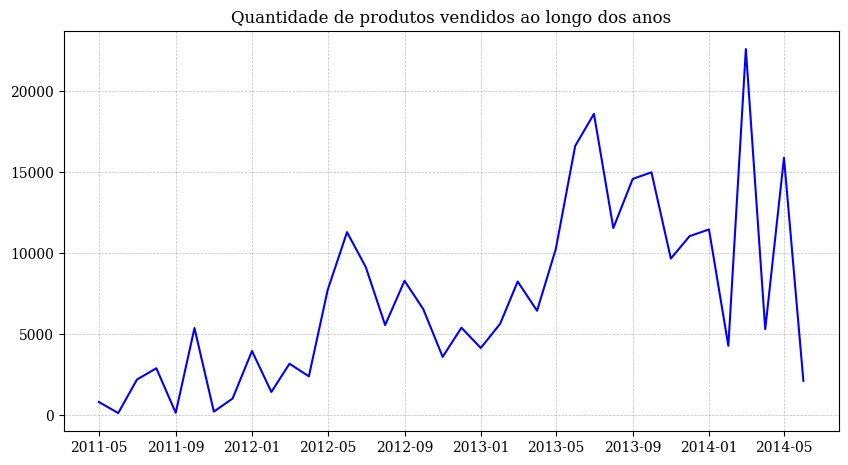

In [29]:
fig, ax = plt.subplots(figsize=(10, 5.2))

df_sorted = monthly_sales.sort_values('month', ascending=True)

xs = df_sorted['month']
ys = df_sorted['orderqty']

ax.plot(xs, ys, color='blue')

ax.set_title('Quantidade de produtos vendidos ao longo dos anos')
ax.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.5)

plt.show()

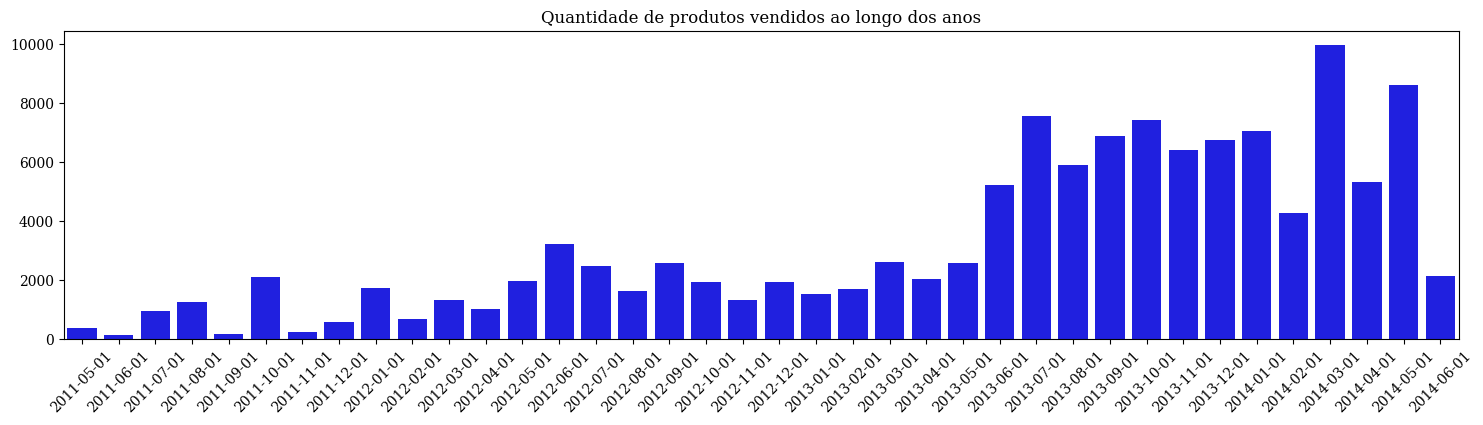

In [38]:
df['month'] = pd.to_datetime(df['month'])

df_sorted = df.sort_values('month')

fig, axs = plt.subplots(figsize=(18, 4))

ax = sns.countplot(x='month', data=df_sorted, color='blue')

ax.set_xlabel('')
ax.set_ylabel('')

plt.xticks(rotation=45)
plt.title('Quantidade de produtos vendidos ao longo dos anos')
plt.show()

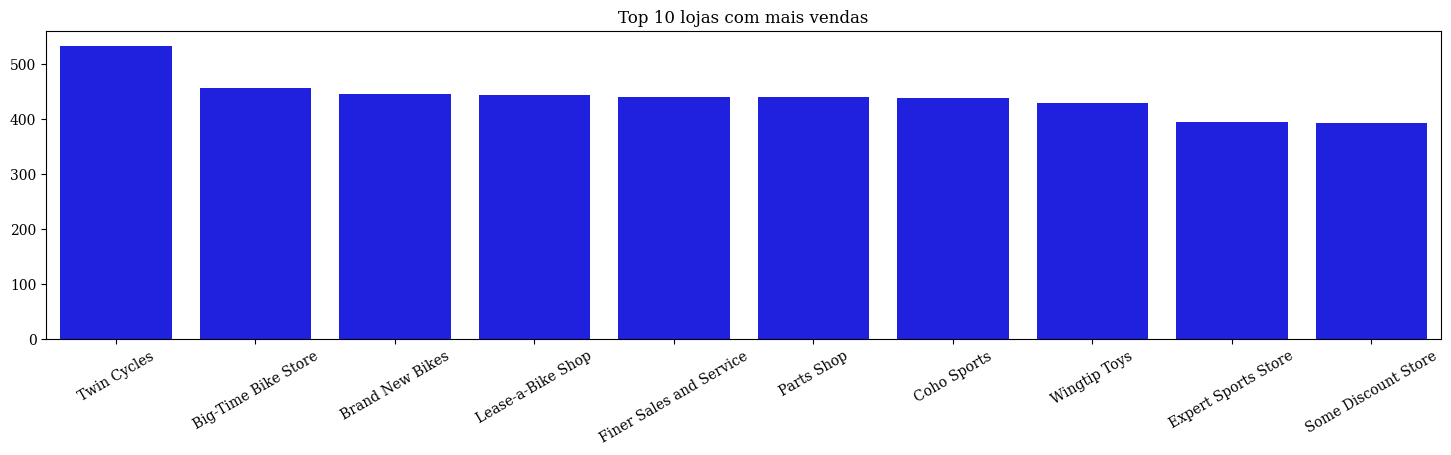

In [43]:
top_10_stores = df['storename'].value_counts().nlargest(11).index[1:]

df_top_10_stores = df[df['storename'].isin(top_10_stores)]

df_top_10_stores['storename'] = pd.Categorical(df_top_10_stores['storename'], categories=top_10_stores, ordered=True)

fig, axs = plt.subplots(figsize=(18, 4))

ax = sns.countplot(x='storename', data=df_top_10_stores, color='blue')

plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('')

plt.title('Top 10 lojas com mais vendas')

plt.show()

# 7.6 Decomposição Sazonal

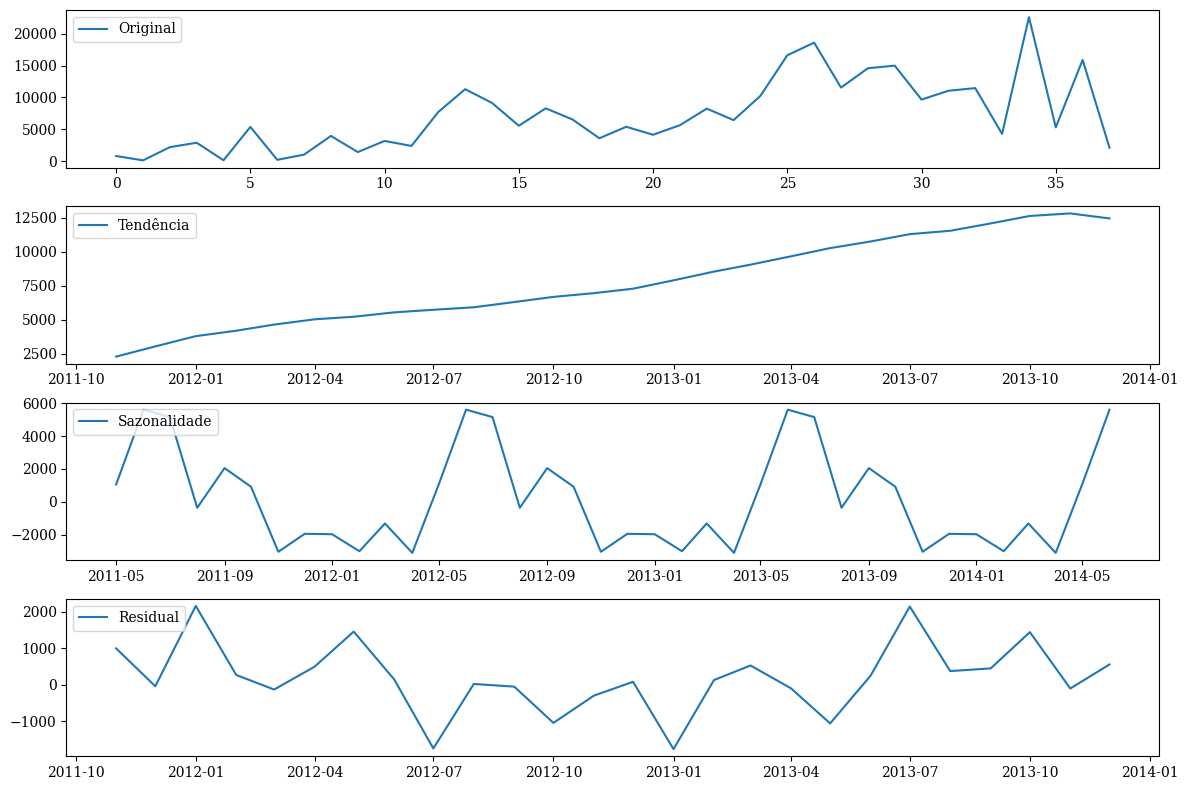

In [47]:
result = seasonal_decompose(monthly_sales.set_index('month')["orderqty"], model='additive', period=12)

def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition: DecomposeResult):
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['orderqty'], label='Original')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(seasonal_decomposition.trend, label='Tendência')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(seasonal_decomposition.seasonal, label='Sazonalidade')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

seasonal_decomposition_plots(data=monthly_sales, seasonal_decomposition=result)

# 7.7 Séries hierárquicas

In [48]:
hts = (
    df
    .groupby([
        'month','productname', 'territoryid', 'storename'])["orderqty"].sum()
    .reset_index()
)

hts.head()

,month,productname,territoryid,storename,orderqty
0,2011-05-01,AWC Logo Cap,1,online,5
1,2011-05-01,AWC Logo Cap,2,online,1
2,2011-05-01,AWC Logo Cap,3,Tandem Sales and Service,2
3,2011-05-01,AWC Logo Cap,3,online,2
4,2011-05-01,AWC Logo Cap,4,online,12


In [49]:
general_hierarchies = [
    ['productname'],
    ['territoryid'],
    ['storename'],
    ['territoryid', 'storename'],
    ['territoryid', 'storename', 'productname']
]

In [50]:
hts = hts.rename(columns={"month": "ds", "orderqty": "y"})

In [51]:
print(hts.columns)

Index(['ds', 'productname', 'territoryid', 'storename', 'y'], dtype='object')


In [52]:
result = aggregate(hts, general_hierarchies)
print(f"Número de elementos na tupla: {len(result)}")
for i, item in enumerate(result):
    print(f"Tipo do elemento {i}: {type(item)}")

Número de elementos na tupla: 3
Tipo do elemento 0: <class 'pandas.core.frame.DataFrame'>
Tipo do elemento 1: <class 'pandas.core.frame.DataFrame'>
Tipo do elemento 2: <class 'dict'>


In [53]:
result = aggregate(hts, general_hierarchies)

Y_df = result[0]

Y_df = Y_df.reset_index()

In [54]:
print(Y_df.head())

      unique_id         ds    y
0  AWC Logo Cap 2011-05-01   40
1  AWC Logo Cap 2011-07-01  103
2  AWC Logo Cap 2011-08-01  137
3  AWC Logo Cap 2011-10-01  240
4  AWC Logo Cap 2011-12-01   25


In [55]:
count = Y_df['unique_id'].value_counts()
Y_df = Y_df[Y_df['unique_id'].isin(count[count >= 5].index)]

In [56]:
test_agg = Y_df.groupby('unique_id').tail(3)
train_agg = Y_df.drop(test_agg.index)

print("Conjunto de Teste:")
print(test_agg)
print("\nConjunto de Treinamento:")
print(train_agg)


Conjunto de Teste:
                                    unique_id         ds    y
32                               AWC Logo Cap 2014-04-01  193
33                               AWC Logo Cap 2014-05-01  456
34                               AWC Logo Cap 2014-06-01   93
46                     All Purpose Bike Stand 2014-04-01   23
47                     All Purpose Bike Stand 2014-05-01   13
...                                       ...        ...  ...
58665  <NA>/online/Women's Mountain Shorts, M 2014-05-01   26
58666  <NA>/online/Women's Mountain Shorts, M 2014-06-01   12
58677  <NA>/online/Women's Mountain Shorts, S 2014-04-01   15
58678  <NA>/online/Women's Mountain Shorts, S 2014-05-01   19
58679  <NA>/online/Women's Mountain Shorts, S 2014-06-01   10

[9918 rows x 3 columns]

Conjunto de Treinamento:
                                    unique_id         ds    y
0                                AWC Logo Cap 2011-05-01   40
1                                AWC Logo Cap 2011-07-01  103


# 7.8 Treinamento do modelo

In [57]:
fcst = StatsForecast(
    df=train_agg,
    models=[AutoARIMA(season_length=12), Naive()],
    freq='MS',
)

In [58]:
Y_hat_df = fcst.forecast(h=3)

In [59]:
xmat = test_agg.merge(Y_hat_df, on=['unique_id', 'ds'])
xmat2 = xmat.copy()

# 7.9 Previsão de demanda

In [60]:
xmat_filtrado = (
    xmat.assign(ds=pd.to_datetime(xmat['ds']))
    .loc[xmat['ds'] >= '2014-03-01']
    .sort_values(by='ds', ascending=True)
)

xmat_filtrado.columns = ['Produtos', 'Data', 'Real', 'Previsão', 'Naive']
xmat_filtrado.head(10)


,Produtos,Data,Real,Previsão,Naive
3125,"4/online/Road 550 W Yellow, 38",2014-03-01,20,9.491197,2.0
1483,"1/online/Touring 1000 Yellow, 50",2014-03-01,21,7.904357,12.0
4217,"6/online/Road 350 W Yellow, 44",2014-03-01,1,0.897713,1.0
1485,"1/online/Touring 1000 Yellow, 54",2014-03-01,6,-0.448576,1.0
4215,"6/online/Road 250 Red, 58",2014-03-01,1,1.155845,2.0
1488,"1/online/Touring 1000 Yellow, 60",2014-03-01,27,1.359477,2.0
1492,"1/online/Touring 2000 Blue, 46",2014-03-01,13,7.973603,15.0
1494,"1/online/Touring 2000 Blue, 50",2014-03-01,9,0.000000,2.0
1495,"1/online/Touring 2000 Blue, 54",2014-03-01,22,0.727350,1.0
4183,"6/online/Mountain 200 Silver, 46",2014-03-01,1,2.701199,3.0


In [61]:
print(xmat_filtrado.head())

                              Produtos       Data  Real  Previsão  Naive
3125    4/online/Road 550 W Yellow, 38 2014-03-01    20  9.491197    2.0
1483  1/online/Touring 1000 Yellow, 50 2014-03-01    21  7.904357   12.0
4217    6/online/Road 350 W Yellow, 44 2014-03-01     1  0.897713    1.0
1485  1/online/Touring 1000 Yellow, 54 2014-03-01     6 -0.448576    1.0
4215         6/online/Road 250 Red, 58 2014-03-01     1  1.155845    2.0


In [62]:
def my_rmse(actual, predicted):
    return np.sqrt(((predicted - actual) ** 2).mean())

def my_mse(actual, predicted):
    return ((predicted - actual) ** 2).mean()

def my_mae(actual, predicted):
    return np.abs(predicted - actual).mean()


def creating_results(p_rec_):
    results = []
    for k in p_rec_['Produtos'].unique():
        k_rmse = my_rmse(p_rec_.loc[p_rec_['Produtos'] == k, 'Real'], p_rec_.loc[p_rec_['Produtos'] == k, 'Previsão'])
        k_mse = my_mse(p_rec_.loc[p_rec_['Produtos'] == k, 'Real'], p_rec_.loc[p_rec_['Produtos'] == k, 'Previsão'])
        k_mae = my_mae(p_rec_.loc[p_rec_['Produtos'] == k, 'Real'], p_rec_.loc[p_rec_['Produtos'] == k, 'Previsão'])

        results.append({'Category': k, 'RMSE': k_rmse, 'MSE': k_mse, 'MAE': k_mae})

    results_df = pd.DataFrame(results)
    return results_df

metrics_results = creating_results(xmat_filtrado)

print(metrics_results)


                                      Category        RMSE           MSE  \
0               4/online/Road 550 W Yellow, 38    7.847696     61.586338   
1             1/online/Touring 1000 Yellow, 50    9.772147     95.494861   
2               6/online/Road 350 W Yellow, 44    0.710127      0.504280   
3             1/online/Touring 1000 Yellow, 54    5.214855     27.194710   
4                    6/online/Road 250 Red, 58    0.155845      0.024288   
...                                        ...         ...           ...   
996   10/online/Short Sleeve Classic Jersey, L    0.848383      0.719754   
997                   4/online/Classic Vest, S   27.745042    769.787358   
998                            Classic Vest, M  204.542619  41837.682917   
999                           HL Mountain Tire   40.257504   1620.666667   
1000          10/online/Sport 100 Helmet, Blue    4.966555     24.666667   

             MAE  
0       6.830398  
1       8.755414  
2       0.524313  
3       4.8

In [63]:
mse_autoarima = mean_squared_error(xmat_filtrado['Real'], xmat_filtrado['Previsão'])
rmse_autoarima = np.sqrt(mse_autoarima)
mae_autoarima = mean_absolute_error(xmat_filtrado['Real'], xmat_filtrado['Previsão'])

print("Métricas para o modelo AutoARIMA:")
print("MSE:", mse_autoarima)
print("RMSE:", rmse_autoarima)
print("MAE:", mae_autoarima)

Métricas para o modelo AutoARIMA:
MSE: 127152.90610689047
RMSE: 356.5850615307524
MAE: 45.928860934819006


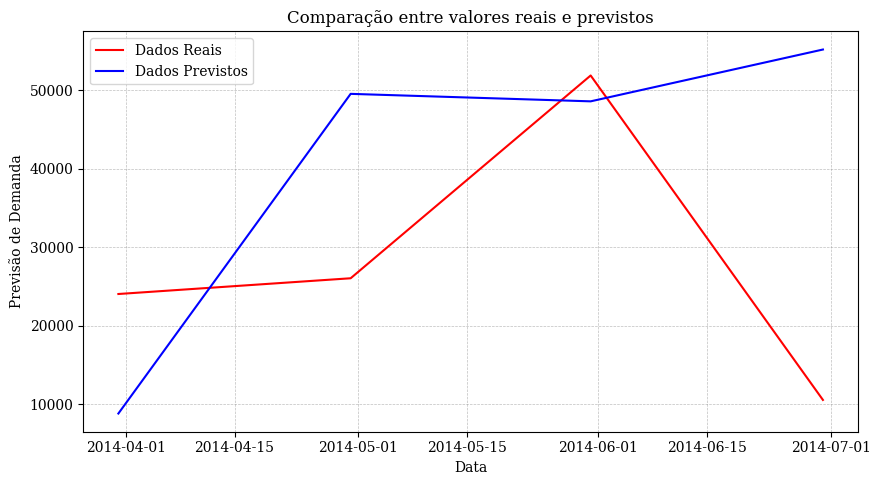

In [64]:
monthly_sales_pred = (
    xmat_filtrado
    .groupby(pd.Grouper(key='Data', freq='M'))['Previsão'].sum()
    .reset_index()
)

monthly_sales_real = (
    xmat_filtrado
    .groupby(pd.Grouper(key='Data', freq='M'))['Real'].sum()
    .reset_index()
)

plt.figure(figsize=(10, 5.2))

plt.plot(monthly_sales_real['Data'], monthly_sales_real['Real'], color='red', label='Dados Reais')
plt.plot(monthly_sales_pred['Data'], monthly_sales_pred['Previsão'], color='blue', label='Dados Previstos')

plt.xlabel('Data')
plt.ylabel('Previsão de Demanda')
plt.title('Comparação entre valores reais e previstos')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

plt.show()


# 7.10 Sazonalidade

In [65]:
Y_hat_df_filtered = xmat2[xmat2['unique_id'].str.contains("AWC Logo Cap")]
Y_hat_df_filtered

,unique_id,ds,y,AutoARIMA,Naive
0,AWC Logo Cap,2014-04-01,193,361.524475,663.0
1,AWC Logo Cap,2014-05-01,456,589.481689,663.0
2,AWC Logo Cap,2014-06-01,93,700.828186,663.0
999,1/Weekend Bike Tours/AWC Logo Cap,2013-04-01,8,3.716773,5.0
1014,1/online/AWC Logo Cap,2014-04-01,18,33.025913,73.0
...,...,...,...,...,...
4885,9/online/AWC Logo Cap,2014-05-01,17,15.190501,17.0
4886,9/online/AWC Logo Cap,2014-06-01,7,14.359314,17.0
5130,<NA>/online/AWC Logo Cap,2014-04-01,102,100.000000,100.0
5131,<NA>/online/AWC Logo Cap,2014-05-01,143,100.000000,100.0


In [66]:
Y_hat_df_filtered.head()

,unique_id,ds,y,AutoARIMA,Naive
0,AWC Logo Cap,2014-04-01,193,361.524475,663.0
1,AWC Logo Cap,2014-05-01,456,589.481689,663.0
2,AWC Logo Cap,2014-06-01,93,700.828186,663.0
999,1/Weekend Bike Tours/AWC Logo Cap,2013-04-01,8,3.716773,5.0
1014,1/online/AWC Logo Cap,2014-04-01,18,33.025913,73.0


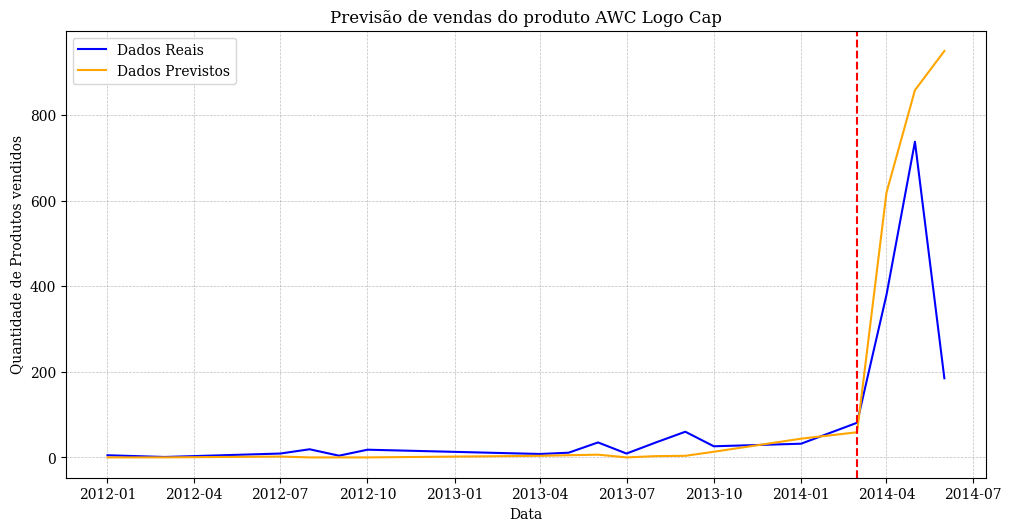

In [67]:
monthly_sales_pred = (
    Y_hat_df_filtered
    .groupby("ds")["AutoARIMA"].sum()
    .reset_index()
)

monthly_sales_y = (
    Y_hat_df_filtered
    .groupby("ds")["y"].sum()
    .reset_index()
)

# O restante do código para plotagem permanece o mesmo
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

df_sorted_pred = monthly_sales_pred.sort_values('ds', ascending=True)
df_sorted_y = monthly_sales_y.sort_values('ds', ascending=True)

xs_pred = df_sorted_pred['ds']
ys_pred = df_sorted_pred['AutoARIMA']  # Substituído 'pred' por 'AutoARIMA'

xs_y = df_sorted_y['ds']
ys_y = df_sorted_y['y']

plt.plot(xs_y, ys_y, color='blue', label='Dados Reais')  # Substitua 'blue' pelo código de cor exato para cerulean
plt.plot(xs_pred, ys_pred, color='orange', label='Dados Previstos')  # Substitua 'orange' pelo código de cor exato para web_orange

date_to_plot = pd.to_datetime('2014-03-01')
plt.axvline(x=date_to_plot, color='red', linestyle='--')

plt.title('Previsão de vendas do produto AWC Logo Cap')
plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos vendidos')

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.5)  # Substitua 'grey' pelo código de cor exato para neutral_500

plt.show()

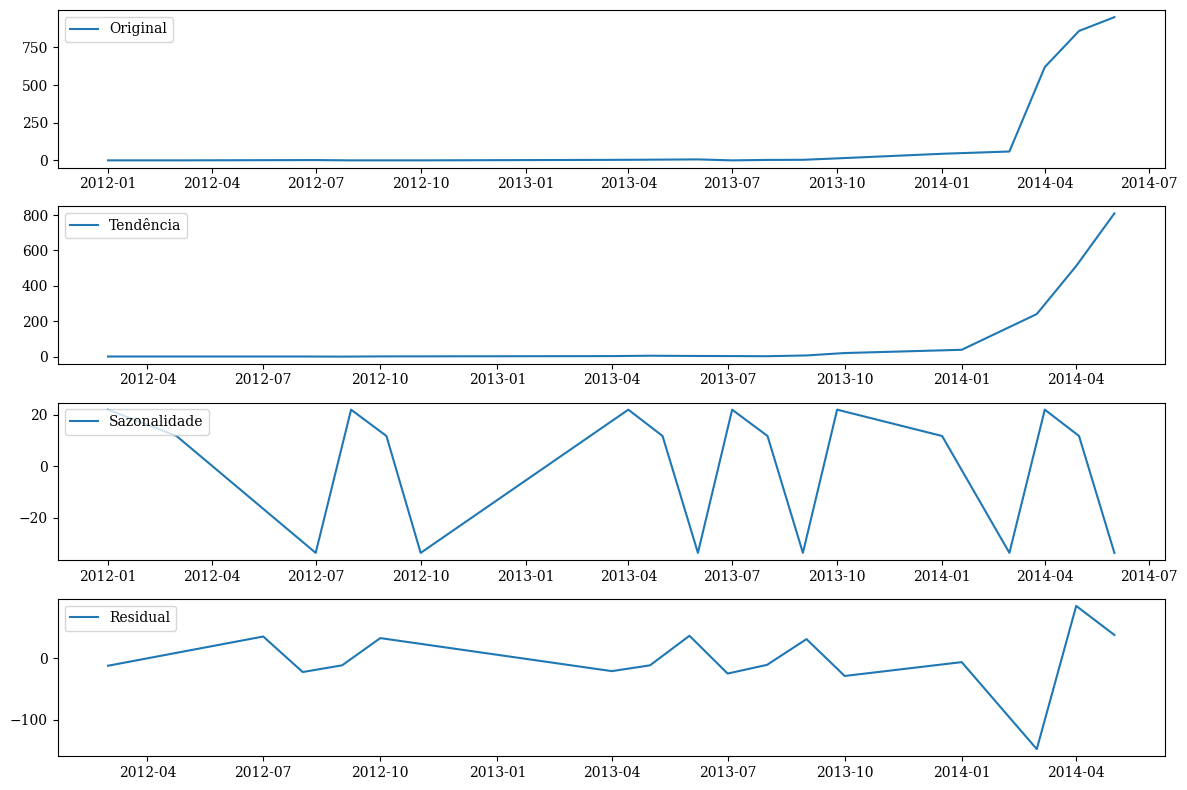

In [68]:
monthly_sales = (
    Y_hat_df_filtered
    .groupby("ds")["AutoARIMA"].sum()
    .reset_index()
)

result = seasonal_decompose(monthly_sales.set_index('ds')["AutoARIMA"], model='additive', period=3)

def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition):

    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['ds'], data['AutoARIMA'], label='Original')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(data['ds'], seasonal_decomposition.trend, label='Tendência')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(data['ds'], seasonal_decomposition.seasonal, label='Sazonalidade')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(data['ds'], seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

seasonal_decomposition_plots(data=monthly_sales, seasonal_decomposition=result)

# Q.8 Regressão linear

# 8.1 Pré-processamento



In [69]:
df2 = df.copy()
df2.head()

,id_detalhe_pedido,product_fk,customerid,shiptoadress_fk,creditcard_fk,unitprice,orderqty,revenue_wo_taxandfreight,orderdate,order_status_name,...,productlistprice,productsize,productweight,productdaystonanufacture,productline,productclass,productstyle,productquantity,productunitprice,month
0,1145,214,29523,593,15321,4.750000000,26,123.500000000,2011-07-01 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2011-07-01
1,9922,214,29504,973,18031,4.750000000,32,152.000000000,2012-04-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2012-04-01
2,10783,348,29734,517,1346,14.500000000,11,159.500000000,2012-05-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2012-05-01
3,10900,348,29692,494,923,14.500000000,11,159.500000000,2012-05-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2012-05-01
4,14472,348,29699,456,10064,14.500000000,11,159.500000000,2012-06-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2012-06-01


In [70]:
df2.columns

Index(['id_detalhe_pedido', 'product_fk', 'customerid', 'shiptoadress_fk',
       'creditcard_fk', 'unitprice', 'orderqty', 'revenue_wo_taxandfreight',
       'orderdate', 'order_status_name', 'territoryid', 'storename',
       'productid', 'productsalesid', 'productcompleteid', 'productname',
       'productaakeflag', 'productfinishedgoodsflag',
       'productsafetystocklevel', 'productreorderpoint', 'productstandardeost',
       'productlistprice', 'productsize', 'productweight',
       'productdaystonanufacture', 'productline', 'productclass',
       'productstyle', 'productquantity', 'productunitprice', 'month'],
      dtype='object')

In [71]:
hts = (
    df2
    .groupby([
        'month', 'productname', 'territoryid',
        'storename'])['unitprice', 'orderqty', 'revenue_wo_taxandfreight',
                       'productsafetystocklevel', 'productreorderpoint',
                       'productstandardeost', 'productlistprice',
                       'productsize', 'productweight', 'productdaystonanufacture',
                       'productline', 'productclass', 'productstyle', 'productquantity',
                       'productunitprice'].sum().reset_index()
)

hts.head()

,month,productname,territoryid,storename,orderqty
0,2011-05-01,AWC Logo Cap,1,online,5
1,2011-05-01,AWC Logo Cap,2,online,1
2,2011-05-01,AWC Logo Cap,3,Tandem Sales and Service,2
3,2011-05-01,AWC Logo Cap,3,online,2
4,2011-05-01,AWC Logo Cap,4,online,12


In [72]:
hts = hts.set_index('month')
hts.index = pd.to_datetime(hts.index)

# 8.2 Feature Engineering

In [73]:
def concatenar_valores(row):
    return '/'.join(row)

hts['concat'] = hts[['productname', 'territoryid', 'storename']].apply(concatenar_valores, axis=1)
hts.head()

,productname,territoryid,storename,orderqty,concat
month,,,,,
2011-05-01,AWC Logo Cap,1,online,5,AWC Logo Cap/1/online
2011-05-01,AWC Logo Cap,2,online,1,AWC Logo Cap/2/online
2011-05-01,AWC Logo Cap,3,Tandem Sales and Service,2,AWC Logo Cap/3/Tandem Sales and Service
2011-05-01,AWC Logo Cap,3,online,2,AWC Logo Cap/3/online
2011-05-01,AWC Logo Cap,4,online,12,AWC Logo Cap/4/online


In [75]:
hts['concat'] = hts['productname'] + hts['territoryid'].astype(str) + hts['storename']

In [76]:
hts2 = hts.drop('concat', axis=1)
df_valores_concatenados = hts.loc[:, ['concat']]

In [77]:
hts2.columns

Index(['productname', 'territoryid', 'storename', 'orderqty'], dtype='object')

In [78]:
label_encoder = LabelEncoder()
hts2['storename'] = label_encoder.fit_transform(hts2['storename'])
hts2['productname'] = label_encoder.fit_transform(hts2['productname'])
hts2['territoryid'] = label_encoder.fit_transform(hts2['territoryid'])

df_concat = hts2.copy()

In [79]:
hts2

,productname,territoryid,storename,orderqty
month,,,,
2011-05-01,0,0,528,5
2011-05-01,0,2,528,1
2011-05-01,0,3,452,2
2011-05-01,0,3,528,2
2011-05-01,0,4,528,12
...,...,...,...,...
2014-06-01,262,4,528,1
2014-06-01,262,7,528,1
2014-06-01,262,8,528,1


In [80]:
# modelagem

# 8.3 Treinamento Xgboost

In [81]:
train = df2.loc[df2['month'] < '2014-04-01']
test = df2.loc[df2['month'] >= '2014-04-01']

features = ['unitprice', 'revenue_wo_taxandfreight', 'productsafetystocklevel',
            'productreorderpoint', 'productstandardeost', 'productlistprice',
            'productsize', 'productweight', 'productdaystonanufacture',
            'productline', 'productclass', 'productstyle', 'productquantity',
            'productunitprice', 'storename', 'territoryid', 'productname']

target = 'orderqty'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [82]:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        try:
            X_train[col] = X_train[col].astype(float)
        except ValueError:
            le = LabelEncoder()
            X_train[col] = le.fit_transform(X_train[col])

In [83]:
print('storename' in X_train.columns)

True


In [85]:
label_encoders = {}
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].fillna('Missing'))
        label_encoders[col] = le

for col in X_test.columns:
    if col in label_encoders:
        X_test[col] = label_encoders[col].transform(X_test[col].fillna('Missing'))
    else:
        try:
            X_test[col] = X_test[col].astype(float)
        except ValueError:
            pass

In [86]:
for key in label_encoders.keys():
    print(key)

In [87]:
for col in ['storename', 'territoryid', 'productname']:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

In [88]:
for col in ['storename', 'territoryid', 'productname']:
    if X_train[col].dtype == 'object' or X_test[col].dtype == 'object':
        le = LabelEncoder()
        # Combine o treino e o teste para o ajuste do encoder para garantir a cobertura de todas as categorias
        le.fit(list(X_train[col].fillna('Missing')) + list(X_test[col].fillna('Missing')))
        X_train[col] = le.transform(X_train[col].fillna('Missing'))
        X_test[col] = le.transform(X_test[col].fillna('Missing'))

In [89]:
print(X_train.dtypes)
print(X_test.dtypes)

unitprice                   float64
revenue_wo_taxandfreight    float64
productsafetystocklevel       int64
productreorderpoint           int64
productstandardeost           int64
productlistprice              int64
productsize                   int64
productweight                 int64
productdaystonanufacture      int64
productline                   int64
productclass                  int64
productstyle                  int64
productquantity               int64
productunitprice              int64
storename                     int64
territoryid                   int64
productname                   int64
dtype: object
unitprice                   float64
revenue_wo_taxandfreight    float64
productsafetystocklevel      object
productreorderpoint          object
productstandardeost          object
productlistprice             object
productsize                  object
productweight                object
productdaystonanufacture     object
productline                  object
productclass  

In [101]:
for column in X_train.columns:
    unique_values = X_train[column].unique()
    non_numeric_values = [value for value in unique_values if not isinstance(value, (int, float))]
    if non_numeric_values:
        print(f"Coluna '{column}' tem valores não numéricos:", non_numeric_values)

Coluna 'productsafetystocklevel' tem valores não numéricos: [0]
Coluna 'productreorderpoint' tem valores não numéricos: [0]
Coluna 'productstandardeost' tem valores não numéricos: [0]
Coluna 'productlistprice' tem valores não numéricos: [0]
Coluna 'productsize' tem valores não numéricos: [0]
Coluna 'productweight' tem valores não numéricos: [0]
Coluna 'productdaystonanufacture' tem valores não numéricos: [0]
Coluna 'productline' tem valores não numéricos: [0]
Coluna 'productclass' tem valores não numéricos: [0]
Coluna 'productstyle' tem valores não numéricos: [0]
Coluna 'productquantity' tem valores não numéricos: [0]
Coluna 'productunitprice' tem valores não numéricos: [0]
Coluna 'storename' tem valores não numéricos: [20, 440, 249, 436, 284, 412, 224, 363, 297, 222, 49, 494, 453, 477, 260, 461, 387, 134, 85, 206, 307, 159, 97, 169, 216, 252, 393, 430, 480, 73, 141, 173, 419, 407, 460, 94, 329, 338, 341, 248, 439, 275, 293, 361, 366, 438, 143, 442, 149, 3, 204, 28, 27, 277, 90, 194, 1

In [102]:
print(X_train.dtypes)

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

print(X_train.dtypes)
print(X_test.dtypes)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

unitprice                   float64
revenue_wo_taxandfreight    float64
productsafetystocklevel       int64
productreorderpoint           int64
productstandardeost           int64
productlistprice              int64
productsize                   int64
productweight                 int64
productdaystonanufacture      int64
productline                   int64
productclass                  int64
productstyle                  int64
productquantity               int64
productunitprice              int64
storename                     int64
territoryid                   int64
productname                   int64
dtype: object
unitprice                   float64
revenue_wo_taxandfreight    float64
productsafetystocklevel       int64
productreorderpoint           int64
productstandardeost           int64
productlistprice              int64
productsize                   int64
productweight                 int64
productdaystonanufacture      int64
productline                   int64
productclass  

In [103]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

print(X_train.dtypes)
print(X_test.dtypes)

unitprice                   float64
revenue_wo_taxandfreight    float64
productsafetystocklevel     float64
productreorderpoint         float64
productstandardeost         float64
productlistprice            float64
productsize                 float64
productweight               float64
productdaystonanufacture    float64
productline                 float64
productclass                float64
productstyle                float64
productquantity             float64
productunitprice            float64
storename                   float64
territoryid                 float64
productname                 float64
dtype: object
unitprice                   float64
revenue_wo_taxandfreight    float64
productsafetystocklevel     float64
productreorderpoint         float64
productstandardeost         float64
productlistprice            float64
productsize                 float64
productweight               float64
productdaystonanufacture    float64
productline                 float64
productclass  

In [104]:
params = {
    'objective': 'reg:squarederror',  # Para regressão
    'eval_metric': 'rmse',             # Métrica de avaliação
    'early_stopping_rounds': 10,       # Parada antecipada
    'verbose': True                    # Exibir mensagens de progresso
}

model = xgb.train(params, dtrain, evals=[(dtest, "Test")])

[0]	Test-rmse:1.35342
[1]	Test-rmse:0.98364
[2]	Test-rmse:0.74639
[3]	Test-rmse:0.55769
[4]	Test-rmse:0.42367
[5]	Test-rmse:0.32790
[6]	Test-rmse:0.26133
[7]	Test-rmse:0.21494
[8]	Test-rmse:0.18612
[9]	Test-rmse:0.16863


In [105]:
y_pred = model.predict(dtest)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.16863093400678533
MAE: 0.07510881521794163


# 8.4 Métricas de avaliação

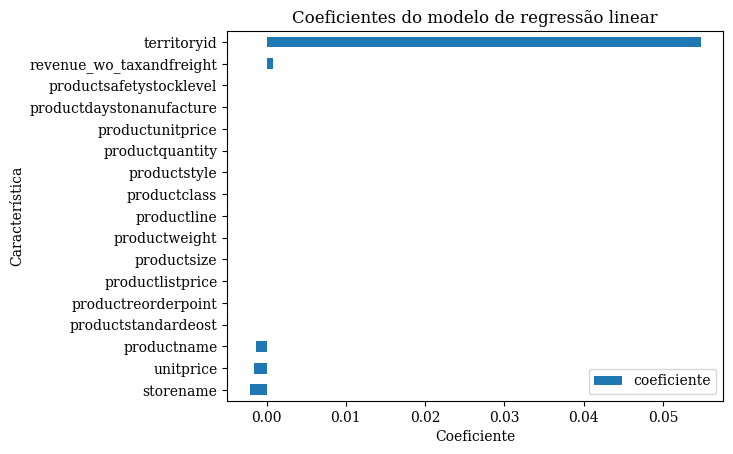

In [111]:
coeficientes = reg.coef_
nomes_caracteristicas = X_train.columns

fi = pd.DataFrame(data=coeficientes, index=nomes_caracteristicas, columns=['coeficiente'])

fi = fi.sort_values('coeficiente')

fi.plot(kind='barh', title='Coeficientes do modelo de regressão linear')
plt.xlabel('Coeficiente')
plt.ylabel('Característica')
plt.show()

In [112]:
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)

X_test_imputed = imputer.transform(X_test)

reg.fit(X_train_imputed, y_train)

test['prediction'] = reg.predict(X_test_imputed)

In [113]:
df1 = hts2.copy()
df1['prediction'] = pd.Series([float('NaN')] * len(df1), index=df1.index)

In [114]:
print(len(test['prediction'].values))

df1.iloc[-len(test['prediction'].values):, df1.columns.get_loc('prediction')] = test['prediction'].values

16058


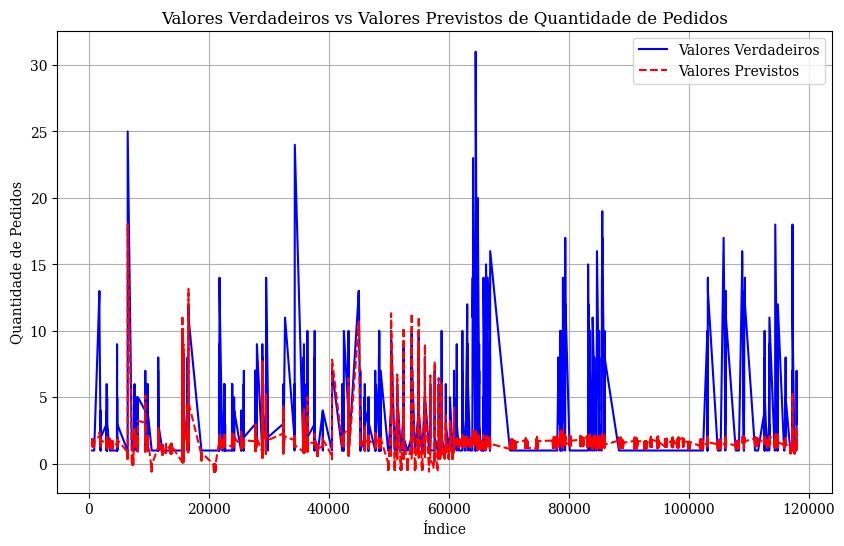

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(test['orderqty'], label='Valores Verdadeiros', color='blue', linestyle='-')
plt.plot(test['prediction'], label='Valores Previstos', color='red', linestyle='--')
plt.title('Valores Verdadeiros vs Valores Previstos de Quantidade de Pedidos')
plt.xlabel('Índice')
plt.ylabel('Quantidade de Pedidos')
plt.legend()
plt.grid(True)
plt.show()

In [120]:
def my_rmse(x,y):
    return np.round(np.sqrt(mse(x.values,y.values)), 2)

def my_mse(x, y):
    return np.round(mse(x.values, y.values), 2)

def my_mae(x, y):
    return np.round(np.nanmean(abs(x.values -  y.values)), 2)

k_rmse = my_rmse(test['orderqty'], test['prediction'])
k_mse = my_mse(test['orderqty'], test['prediction'])
k_mae = my_mae(test['orderqty'], test['prediction'])

results_xgboost = {'RMSE': [k_rmse], 'MSE': [k_mse], 'MAE': [k_mae]}
results_df_xgboost = pd.DataFrame(results_xgboost)
results_df_xgboost

,RMSE,MSE,MAE
0,1.49,2.22,0.84


In [121]:
metrics_results = creating_results(xmat_filtrado)
df_resultado_metricas = pd.concat([metrics_results, results_df_xgboost], ignore_index=True)
df_resultado_metricas = df_resultado_metricas.rename(index={0: 'ARIMA', 1: 'XGBoost'})

styled_df = df_resultado_metricas.style.set_caption('Resultados das Métricas').background_gradient(cmap='Blues')

styled_df

,Category,RMSE,MSE,MAE
ARIMA,"4/online/Road 550 W Yellow, 38",7.850000,61.590000,6.830000
XGBoost,"1/online/Touring 1000 Yellow, 50",9.770000,95.490000,8.760000
2,"6/online/Road 350 W Yellow, 44",0.710000,0.500000,0.520000
3,"1/online/Touring 1000 Yellow, 54",5.210000,27.190000,4.820000
4,"6/online/Road 250 Red, 58",0.160000,0.020000,0.160000
5,"1/online/Touring 1000 Yellow, 60",21.650000,468.890000,17.700000
6,"1/online/Touring 2000 Blue, 46",5.030000,25.260000,5.030000
7,"1/online/Touring 2000 Blue, 50",9.000000,81.000000,9.000000
8,"1/online/Touring 2000 Blue, 54",15.610000,243.580000,13.120000
9,"6/online/Mountain 200 Silver, 46",1.120000,1.250000,0.980000


In [122]:
df_concat['produto/pais/loja'] = df_valores_concatenados['concat']

In [123]:
df_concat

,productname,territoryid,storename,orderqty,produto/pais/loja
month,,,,,
2011-05-01,0,0,528,5,AWC Logo Cap1online
2011-05-01,0,2,528,1,AWC Logo Cap2online
2011-05-01,0,3,452,2,AWC Logo Cap3Tandem Sales and Service
2011-05-01,0,3,528,2,AWC Logo Cap3online
2011-05-01,0,4,528,12,AWC Logo Cap4online
...,...,...,...,...,...
2014-06-01,262,4,528,1,"Women's Mountain Shorts, S4online"
2014-06-01,262,7,528,1,"Women's Mountain Shorts, S7online"
2014-06-01,262,8,528,1,"Women's Mountain Shorts, S8online"


In [124]:
print(df.columns)

Index(['id_detalhe_pedido', 'product_fk', 'customerid', 'shiptoadress_fk',
       'creditcard_fk', 'unitprice', 'orderqty', 'revenue_wo_taxandfreight',
       'orderdate', 'order_status_name', 'territoryid', 'storename',
       'productid', 'productsalesid', 'productcompleteid', 'productname',
       'productaakeflag', 'productfinishedgoodsflag',
       'productsafetystocklevel', 'productreorderpoint', 'productstandardeost',
       'productlistprice', 'productsize', 'productweight',
       'productdaystonanufacture', 'productline', 'productclass',
       'productstyle', 'productquantity', 'productunitprice', 'month'],
      dtype='object')


In [125]:
df_concat['prediction'] = pd.Series([float('NaN')] * len(df_concat), index=df_concat.index)

In [126]:
prediction_length = len(test['prediction'].values)

num_rows = min(prediction_length, len(df_concat))

df_concat.iloc[-num_rows:, df_concat.columns.get_loc('prediction')] = test['prediction'].values[:num_rows]

In [127]:
df_concat

,productname,territoryid,storename,orderqty,produto/pais/loja,prediction
month,,,,,,
2011-05-01,0,0,528,5,AWC Logo Cap1online,NaN
2011-05-01,0,2,528,1,AWC Logo Cap2online,NaN
2011-05-01,0,3,452,2,AWC Logo Cap3Tandem Sales and Service,NaN
2011-05-01,0,3,528,2,AWC Logo Cap3online,NaN
2011-05-01,0,4,528,12,AWC Logo Cap4online,NaN
...,...,...,...,...,...,...
2014-06-01,262,4,528,1,"Women's Mountain Shorts, S4online",1.374833
2014-06-01,262,7,528,1,"Women's Mountain Shorts, S7online",1.759115
2014-06-01,262,8,528,1,"Women's Mountain Shorts, S8online",1.893061


In [128]:
print(df.columns)

Index(['id_detalhe_pedido', 'product_fk', 'customerid', 'shiptoadress_fk',
       'creditcard_fk', 'unitprice', 'orderqty', 'revenue_wo_taxandfreight',
       'orderdate', 'order_status_name', 'territoryid', 'storename',
       'productid', 'productsalesid', 'productcompleteid', 'productname',
       'productaakeflag', 'productfinishedgoodsflag',
       'productsafetystocklevel', 'productreorderpoint', 'productstandardeost',
       'productlistprice', 'productsize', 'productweight',
       'productdaystonanufacture', 'productline', 'productclass',
       'productstyle', 'productquantity', 'productunitprice', 'month'],
      dtype='object')


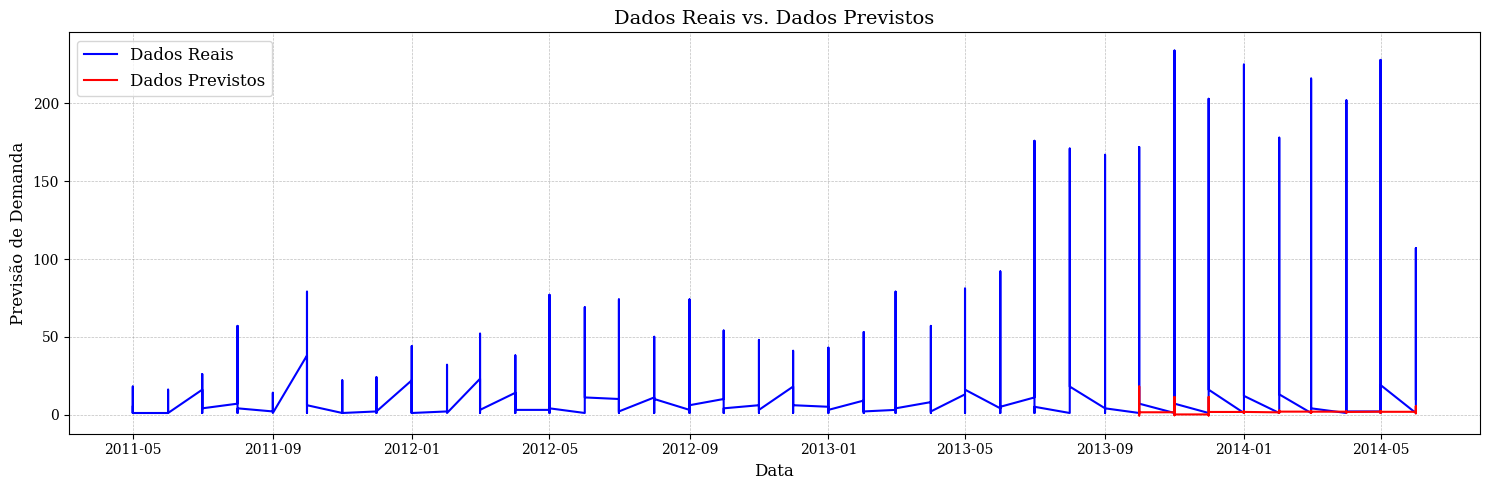

In [131]:
cor_dados_reais = 'blue'
cor_dados_previstos = 'red'

estilo_dados_previstos = 'solid'

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df_concat.index, df_concat['orderqty'], color=cor_dados_reais, label='Dados Reais')

ax.plot(df_concat.index, df_concat['prediction'], color=cor_dados_previstos, linestyle=estilo_dados_previstos, label='Dados Previstos')

ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Previsão de Demanda', fontsize=12)
ax.set_title('Dados Reais vs. Dados Previstos', fontsize=14)

ax.legend(fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

plt.tight_layout()

plt.show()

# Q9. Previsão de demanda - País

In [154]:
df_concat

,productname,territoryid,storename,orderqty,produto/pais/loja,prediction,local
month,,,,,,,
2011-05-01,0,0,528,5,AWC Logo Cap1online,NaN,EUA
2011-05-01,0,2,528,1,AWC Logo Cap2online,NaN,Resto do Mundo
2011-05-01,0,3,452,2,AWC Logo Cap3Tandem Sales and Service,NaN,Resto do Mundo
2011-05-01,0,3,528,2,AWC Logo Cap3online,NaN,Resto do Mundo
2011-05-01,0,4,528,12,AWC Logo Cap4online,NaN,Resto do Mundo
...,...,...,...,...,...,...,...
2014-06-01,262,4,528,1,"Women's Mountain Shorts, S4online",1.374833,Resto do Mundo
2014-06-01,262,7,528,1,"Women's Mountain Shorts, S7online",1.759115,Resto do Mundo
2014-06-01,262,8,528,1,"Women's Mountain Shorts, S8online",1.893061,Resto do Mundo


In [155]:
df_concat['local'] = 'Resto do Mundo'
df_concat.loc[df_concat['territoryid'] == 0, 'local'] = 'EUA'

In [158]:
demanda_usa = df_selected[df_selected['local'] == 'EUA']['orderqty'].sum()
demanda_resto_mundo = df_selected[df_selected['local'] == 'Resto do Mundo']['orderqty'].sum()

In [159]:
if demanda_usa > demanda_resto_mundo:
    print("Os EUA apresentaram mais crescimento na demanda nos três meses previstos.")
elif demanda_usa < demanda_resto_mundo:
    print("O Resto do Mundo apresentou mais crescimento na demanda nos três meses previstos.")
else:
    print("Os EUA e o Resto do Mundo tiveram o mesmo crescimento na demanda nos três meses previstos.")

O Resto do Mundo apresentou mais crescimento na demanda nos três meses previstos.


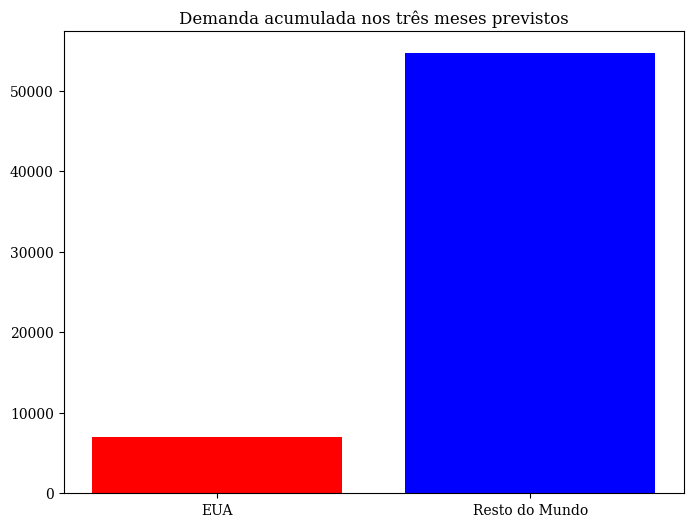

In [161]:
locais = ['EUA', 'Resto do Mundo']
demandas = [demanda_usa, demanda_resto_mundo]

plt.figure(figsize=(8, 6))
plt.bar(locais, demandas, color=['red', 'blue'])
plt.title('Demanda acumulada nos três meses previstos')
plt.show()

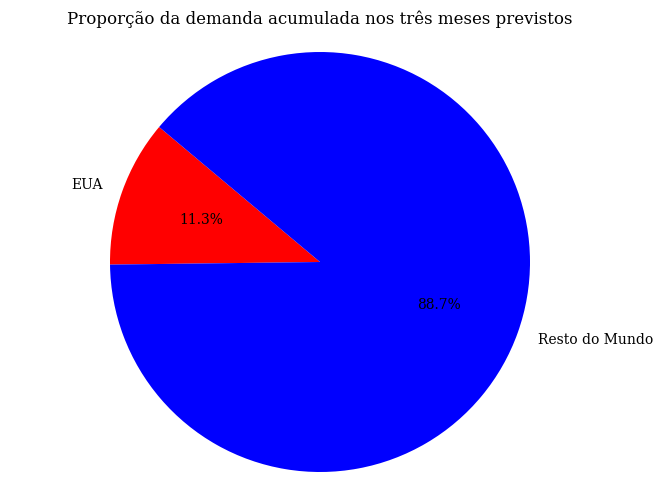

In [163]:
locais = ['EUA', 'Resto do Mundo']
demandas = [demanda_usa, demanda_resto_mundo]

plt.figure(figsize=(8, 6))
plt.pie(demandas, labels=locais, autopct='%1.1f%%', colors=['red', 'blue'], startangle=140)
plt.title('Proporção da demanda acumulada nos três meses previstos')
plt.axis('equal')
plt.show()

# Q10. Previsão demanda de zíper

In [164]:
data_inicial = '2014-04-01'
data_final = '2014-06-30'

df_selected = df_concat.loc[data_inicial:data_final]

df_new = df_selected[['produto/pais/loja', 'orderqty', 'prediction']].copy()
df_luvas = df_new[df_new['produto/pais/loja'].str.contains('Gloves')]
df_luvas

,produto/pais/loja,orderqty,prediction
month,,,
2014-04-01,"Full Finger Gloves, L8online",5,1.844625
2014-04-01,"Full Finger Gloves, M8online",2,1.735138
2014-04-01,"Full Finger Gloves, S8online",1,1.516165
2014-04-01,"Half Finger Gloves, L1online",4,1.789882
2014-04-01,"Half Finger Gloves, L10online",2,1.297191
...,...,...,...
2014-06-01,"Half Finger Gloves, S6online",2,1.765396
2014-06-01,"Half Finger Gloves, S7online",1,1.436935
2014-06-01,"Half Finger Gloves, S8Requisite Part Supply",1,1.765396


In [165]:
estimativa_demanda_luvas = df_luvas['prediction'].sum()
pares = estimativa_demanda_luvas / 2
estimativa_demanda_ziperes = estimativa_demanda_luvas

print(f'O fornecedor tem uma estimativa de {round(estimativa_demanda_ziperes)} zíperes necessários para {round(pares)} pares para os próximos 3 meses.')

O fornecedor tem uma estimativa de 182 zíperes necessários para 91 pares para os próximos 3 meses.
